# JavaScript执行（三）：你知道现在有多少种函数吗？

在 JavaScript，切换上下文最主要的场景是函数调用。在这一课，我们就来讲讲函数调用切换上下文的事情。我们在讲函数调用之前，首先来认识一下函数家族。

### 第一种，普通函数：用 function 关键字定义的函数。


In [1]:
function foo(){
    // code
}

### 第二种，箭头函数：用 => 运算符定义的函数。

In [4]:
const foo2 = () => {
    // code
}

### 第三种，方法：在 class 中定义的函数。

In [5]:
class C {
    foo(){
        //code
    }
}

### 第四种，生成器函数：用 function * 定义的函数。

In [6]:
function* foo(){
    // code
}

### 第五种，类：用 class 定义的类，实际上也是函数。

In [7]:
class Foo {
    constructor(){
        //code
    }
}

### 第六 / 七 / 八种，异步函数：普通函数、箭头函数和生成器函数加上 async 关键字。

In [25]:
async function foo(){
    // code
}
const foo2 = async () => {
    // code
}
async function* foo3(){
    // code
}

### this 关键字的行为

#### this 是执行上下文中很重要的一个组成部分。同一个函数调用方式不同，得到的 this 值也不同，我们看一个例子：

In [ ]:
function showThis(){
    console.log(this);
}

var o = {
    showThis: showThis
}

showThis(); // global
o.showThis(); // o

在这个例子中，我们定义了函数 showThis，我们把它赋值给一个对象 o 的属性，然后尝试分别使用两个引用来调用同一个函数，结果得到了不同的 this 值。

普通函数的 this 值由“调用它所使用的引用”决定，其中奥秘就在于：我们获取函数的表达式，它实际上返回的并非函数本身，而是一个 Reference 类型（记得我们在类型一章讲过七种标准类型吗，正是其中之一）。

Reference 类型由两部分组成：一个对象和一个属性值。不难理解 o.showThis 产生的 Reference 类型，即由对象 o 和属性“showThis”构成。

#### 调用函数时使用的引用，决定了函数执行时刻的 this 值。
    这个设计来自 JavaScript 早年，通过这样的方式，巧妙地模仿了 Java 的语法，但是仍然保持了纯粹的“无类”运行时设施。
    如果，我们把这个例子稍作修改，换成箭头函数，结果就不一样了：

In [ ]:
const showThis2 = () => {
    console.log(this);
}

var o = {
    showThis: showThis
}

showThis2(); // global
o.showThis(); // global

#### 我们看到，改为箭头函数后，不论用什么引用来调用它，都不影响它的 this 值。

接下来我们看看“方法”，它的行为又不一样了：

In [21]:
class C {
    showThis() {
        console.log(this);
    }
}
var o = new C();
var showThis = o.showThis;

showThis(); // undefined
o.showThis(); // o

undefined
C {}


### this 关键字的机制

    在 JavaScript 标准中，为函数规定了用来保存定义时上下文的私有属性[[Environment]]。

    当一个函数执行时，会创建一条新的执行环境记录，记录的外层词法环境（outer lexical environment）会被设置成函数的[[Environment]]。

    这个动作就是切换上下文了，我们假设有这样的代码：

In [37]:
let b = 2;
function foo () {
  console.log(b); // 2
  console.log(a); // error
}

{
  let a = 1
  foo()
}

2


ReferenceError: a is not defined

这里的 foo 能够访问 b（定义时词法环境），却不能访问 a（执行时的词法环境），这就是执行上下文的切换机制了。

JavaScript 用一个栈来管理执行上下文，这个栈中的每一项又包含一个链表。如下图所示：

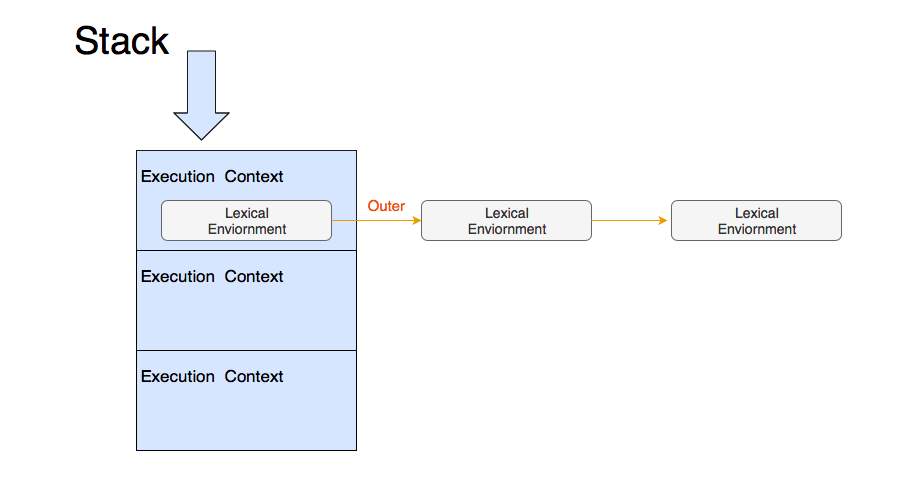

当函数调用时，会入栈一个新的执行上下文，函数调用结束时，执行上下文被出栈。

而 this 则是一个更为复杂的机制，JavaScript 标准定义了 [[thisMode]] 私有属性。[[thisMode]] 私有属性有三个取值。

* lexical：表示从上下文中找 this，这对应了箭头函数。
* global：表示当 this 为 undefined 时，取全局对象，对应了普通函数。
* strict：当严格模式时使用，this 严格按照调用时传入的值，可能为 null 或者 undefined。

我们可以用 strict 达成与上一节中方法的例子一样的效果:

In [36]:
"use strict"
function showThis(){
    console.log(this);
}

var o = {
    showThis: showThis
}

showThis(); // undefined
o.showThis(); // o

undefined
{ showThis: [Function: showThis] }


函数创建新的执行上下文中的词法环境记录时，会根据[[thisMode]]来标记新纪录的[[ThisBindingStatus]]私有属性。

代码执行遇到 this 时，会逐层检查当前词法环境记录中的[[ThisBindingStatus]]，当找到有 this 的环境记录时获取 this 的值。

这样的规则的实际效果是，嵌套的箭头函数中的代码都指向外层 this，例如：

In [38]:
var o = {}
o.foo = function foo(){
    console.log(this);
    return () => {
        console.log(this);
        return () => console.log(this);
    }
}

o.foo()()(); // o, o, o

{ foo: [Function: foo] }
{ foo: [Function: foo] }
{ foo: [Function: foo] }


这个例子中，我们定义了三层嵌套的函数，最外层为普通函数，两层都是箭头函数。这里调用三个函数，获得的 this 值是一致的，都是对象 o。JavaScript 还提供了一系列函数的内置方法来操纵 this 值，下面我们来了解一下。

### 操作 this 的内置函数

Function.prototype.call 和 Function.prototype.apply 可以指定函数调用时传入的 this 值，示例如下：

In [40]:
function foo(a, b, c){
    console.log(this);
    console.log(a, b, c);
}
foo.call({}, 1, 2, 3);
foo.apply({}, [1, 2, 3]);

{}
1 2 3
{}
1 2 3


这里 call 和 apply 作用是一样的，只是传参方式有区别。

此外，还有 Function.prototype.bind 它可以生成一个绑定过的函数，这个函数的 this 值固定了参数：

In [42]:
function foo(a, b, c){
    console.log(this);
    console.log(a, b, c);
}
foo.bind({}, 1, 2, 3)();

{}
1 2 3


有趣的是，call、bind 和 apply 用于不接受 this 的函数类型如箭头、class 都不会报错。这时候，它们无法实现改变 this 的能力，但是可以实现传参。

#### 补充阅读：new 与 this

我们在之前的对象部分已经讲过 new 的执行过程，我们再来看一下：

    以构造器的 prototype 属性（注意与私有字段[[prototype]]的区分）为原型，创建新对象；
    将 this 和调用参数传给构造器，执行；
    如果构造器返回的是对象，则返回，否则返回第一步创建的对象。
    
显然，通过 new 调用函数，跟直接调用的 this 取值有明显区别。那么我们今天讲的这些函数跟 new 搭配又会产生什么效果呢？

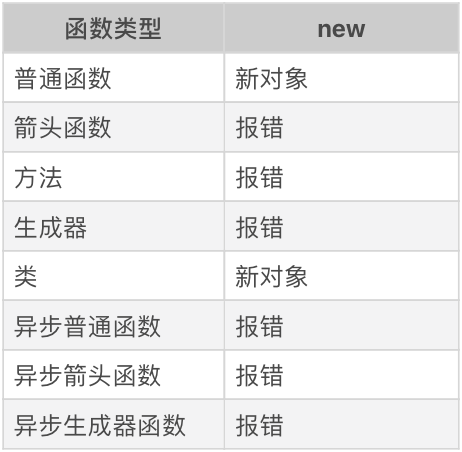

我们可以看到，仅普通函数和类能够跟 new 搭配使用，这倒是给我们省去了不少麻烦。

关于this，Kyle Simpson有四条总结：
1. 由new调用? 绑定到新创建的对象。
2. 由call或者apply(或者bind)调用? 绑定到指定的对象。
3. 由上下文对象调用? 绑定到那个上下文对象。
4. 默认:在严格模式下绑定到undefined，否则绑定到全局对象。
例外：箭头函数不适用以上四条规则，它会继承外层函数调用的 this 绑定(无论 this 绑定到什么)。

https://time.geekbang.org/column/article/83719